# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [44]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2023-03-13 02:02:28--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat.1’

notMNIST_small.mat. 100%[===================>] 112.14M   106MB/s    in 1.1s    

2023-03-13 02:02:30 (106 MB/s) - ‘notMNIST_small.mat.1’ saved [117586976/117586976]



In [45]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [46]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

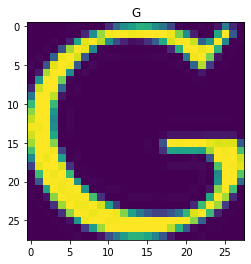

In [47]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

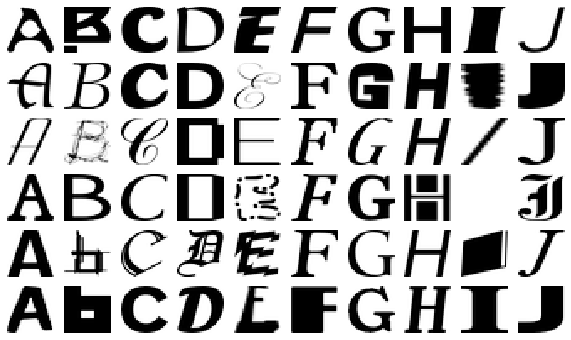

In [48]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [49]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [50]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. Optimizer를 따로 선언해서 사용
3. 초기값은 default로
4. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것
5. Dropout을 0.2 정도로 활용해볼 것
6. Early stopping도 활용해볼 것

In [51]:
from tensorflow.keras.utils import to_categorical

In [52]:
class_n = len(np.unique(y_train))

In [53]:
y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)

In [54]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [56]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979, 10))

In [57]:
tf.keras.backend.clear_session()

model = Sequential()

model.add(Input(shape=(28,28,1)))
model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization()) 
# minibatch normalization (데이터의 분포가 급격하게 바뀌는(covariate_shift) 것을 염려->미니배치 단위로도 스케일링을 해보자 : hidden-> activation-> normalization )
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                        

In [58]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=5,
                   verbose=1,
                   restore_best_weights=True)

In [59]:
history = model.fit(x_train, y_train, validation_split=0.2,
                    verbose=1, epochs=10000,
                    callbacks=[es])

Epoch 1/10000
375/375 [==============================] - 12s 23ms/step - loss: 0.5559 - accuracy: 0.8346 - val_loss: 0.4732 - val_accuracy: 0.8645
Epoch 2/10000
375/375 [==============================] - 8s 21ms/step - loss: 0.3682 - accuracy: 0.8893 - val_loss: 0.5503 - val_accuracy: 0.8445
Epoch 3/10000
375/375 [==============================] - 8s 22ms/step - loss: 0.3191 - accuracy: 0.9019 - val_loss: 0.4109 - val_accuracy: 0.8879
Epoch 4/10000
375/375 [==============================] - 9s 23ms/step - loss: 0.2794 - accuracy: 0.9145 - val_loss: 0.3801 - val_accuracy: 0.8925
Epoch 5/10000
375/375 [==============================] - 8s 21ms/step - loss: 0.2535 - accuracy: 0.9254 - val_loss: 0.3907 - val_accuracy: 0.8955
Epoch 6/10000
375/375 [==============================] - 9s 25ms/step - loss: 0.2272 - accuracy: 0.9307 - val_loss: 0.4642 - val_accuracy: 0.8802
Epoch 7/10000
375/375 [==============================] - 8s 21ms/step - loss: 0.2134 - accuracy: 0.9332 - val_loss: 0.3670 

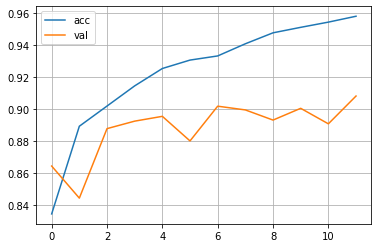

In [60]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['acc','val'])
plt.grid()
plt.show()

In [63]:
y_pred = model.predict(x_test)
from sklearn.metrics import *
accuracy_score(y_test, y_pred)

118/118 [==============================] - 1s 9ms/step


ValueError: ignored

In [67]:
tf.keras.backend.clear_session()

il = tf.keras.Input(shape=(28,28,1))
fl = Flatten()(il)
hl = Dense(512, activation='relu')(fl)
hl = Dense(512, activation='relu')(hl)
bl = BatchNormalization()(hl)
dl = Dropout(0.2)(bl)

hl = Dense(256, activation='relu')(dl)
hl = Dense(256, activation='relu')(hl)
bl = BatchNormalization()(hl)
dl = Dropout(0.2)(bl)

ol = Dense(10, activation='softmax')(dl)

model = tf.keras.models.Model(il, ol)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                             